# Models from Contiguous Epochs With Horizontal Voting Ensembles

Predictive modeling problems where the training dataset is small relative to the number of unlabeled examples are challenging. Neural networks can perform well on these types of problems, although they can suffer from high variance in model performance as measured on training or hold-out validation datasets. This makes choosing which model to use as the final model risky, as there is no clear signal as to which model is better than another toward the end of the training run. The horizontal voting ensemble is a simple method to address this issue. A collection of models saved over contiguous training epochs towards the end of a training run are saved and used as an ensemble that results in more stable and better performance on average randomly choosing a single final model. In this tutorial, you will discover how to reduce the variance of a final deep learning neural network model using a horizontal voting ensemble. After completing this tutorial, you will know:

* It is challenging to choose a final neural network model with high variance on a training dataset.
* Horizontal voting ensembles provide a way to reduce variance and improve average model performance for models with high variance using a single training run.
* How to develop a horizontal voting ensemble in Python using Keras to improve the performance of a final Multilayer Perceptron model for multiclass classification.

## Horizontal Voting Ensemble

Ensemble learning combines the predictions from multiple models. A challenge when using ensemble learning when using deep learning methods is that given very large datasets and large models, a training run may take days, weeks, or even months. Training multiple models may not be feasible. An alternative source of models that may contribute to an ensemble is the state of a single model at different points during training. Horizontal voting is an ensemble method proposed by Jingjing Xie et al. in their 2013 paper *Horizontal and Vertical Ensemble with Deep Representation for Classification*.

The method involves using multiple models from the end of a contiguous block of epochs before the end of training in an ensemble to make predictions. The approach was developed specifically for those predictive modeling problems where the training dataset is relatively small compared to the number of predictions required by the model. This results in a model that has a high variance in performance during training. In this situation, using the final model or any given model toward the end of the training process is risky given the variance in performance.

Instead, the authors suggest using all models in an ensemble from a contiguous block of epochs during training, such as models from the last 200 epochs. The result is predictions by the ensemble that are as good as or better than any single model in the ensemble.

As such, the horizontal voting ensemble method provides an ideal method for both cases where a given model requires vast computational resources to train and/or cases where final model selection is challenging given the high variance of training due to the use of a relatively small training dataset. Now that we are familiar with horizontal voting, we can implement the procedure.

## Horizontal Voting Ensembles Case Study

In this section, we will demonstrate how to use the horizontal voting ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the horizontal voting ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate a horizontal voting ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

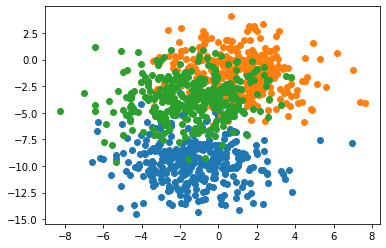

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for a horizontal voting ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 1000 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [5]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=1)

Epoch 1/1000
4/4 [==============================] - 1s 99ms/step - loss: 1.1374 - accuracy: 0.3782 - val_loss: 1.0588 - val_accuracy: 0.3820
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.0712 - accuracy: 0.3534 - val_loss: 1.0175 - val_accuracy: 0.4030
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9873 - accuracy: 0.4565 - val_loss: 0.9850 - val_accuracy: 0.4120
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9644 - accuracy: 0.4572 - val_loss: 0.9594 - val_accuracy: 0.4110
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9320 - accuracy: 0.4696 - val_loss: 0.9402 - val_accuracy: 0.4200
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9123 - accuracy: 0.4809 - val_loss: 0.9251 - val_accuracy: 0.4230
Epoch 7/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.9211 - accuracy: 0.4463 - val_loss: 0.9112 - val_accuracy: 0.4280
Epoch 8/1000


Epoch 59/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5733 - accuracy: 0.7059 - val_loss: 0.6530 - val_accuracy: 0.6910
Epoch 60/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.6082 - accuracy: 0.6684 - val_loss: 0.6481 - val_accuracy: 0.6950
Epoch 61/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5731 - accuracy: 0.7451 - val_loss: 0.6438 - val_accuracy: 0.7000
Epoch 62/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5816 - accuracy: 0.7285 - val_loss: 0.6404 - val_accuracy: 0.7010
Epoch 63/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5848 - accuracy: 0.7326 - val_loss: 0.6387 - val_accuracy: 0.7040
Epoch 64/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5572 - accuracy: 0.7483 - val_loss: 0.6368 - val_accuracy: 0.7030
Epoch 65/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5661 - accuracy: 0.7430 - val_loss: 0.6351 - val_accuracy: 0.7060
Epoch 

4/4 [==============================] - 0s 15ms/step - loss: 0.4771 - accuracy: 0.7729 - val_loss: 0.5663 - val_accuracy: 0.7660
Epoch 117/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5119 - accuracy: 0.7500 - val_loss: 0.5671 - val_accuracy: 0.7640
Epoch 118/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4965 - accuracy: 0.7345 - val_loss: 0.5663 - val_accuracy: 0.7640
Epoch 119/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4782 - accuracy: 0.7564 - val_loss: 0.5662 - val_accuracy: 0.7620
Epoch 120/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5128 - accuracy: 0.7479 - val_loss: 0.5663 - val_accuracy: 0.7600
Epoch 121/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5248 - accuracy: 0.7260 - val_loss: 0.5662 - val_accuracy: 0.7580
Epoch 122/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4977 - accuracy: 0.7467 - val_loss: 0.5673 - val_accuracy: 0.7480
Epoch 123/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.4710 - accuracy: 0.7754 - val_loss: 0.5383 - val_accuracy: 0.7710
Epoch 174/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4811 - accuracy: 0.7712 - val_loss: 0.5363 - val_accuracy: 0.7770
Epoch 175/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4453 - accuracy: 0.8178 - val_loss: 0.5332 - val_accuracy: 0.7830
Epoch 176/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4448 - accuracy: 0.7929 - val_loss: 0.5287 - val_accuracy: 0.7830
Epoch 177/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4647 - accuracy: 0.7992 - val_loss: 0.5270 - val_accuracy: 0.7830
Epoch 178/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4696 - accuracy: 0.7691 - val_loss: 0.5267 - val_accuracy: 0.7850
Epoch 179/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4891 - accuracy: 0.7639 - val_loss: 0.5283 - val_accuracy: 0.7830
Epoch 180/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.4309 - accuracy: 0.8145 - val_loss: 0.5056 - val_accuracy: 0.7860
Epoch 231/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4120 - accuracy: 0.8188 - val_loss: 0.5029 - val_accuracy: 0.7860
Epoch 232/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4157 - accuracy: 0.7938 - val_loss: 0.5014 - val_accuracy: 0.7890
Epoch 233/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4196 - accuracy: 0.8250 - val_loss: 0.5016 - val_accuracy: 0.7860
Epoch 234/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3998 - accuracy: 0.8178 - val_loss: 0.5020 - val_accuracy: 0.7840
Epoch 235/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4195 - accuracy: 0.8053 - val_loss: 0.5024 - val_accuracy: 0.7840
Epoch 236/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3963 - accuracy: 0.8125 - val_loss: 0.5030 - val_accuracy: 0.7860
Epoch 237/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.4064 - accuracy: 0.8209 - val_loss: 0.4818 - val_accuracy: 0.7940
Epoch 288/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4031 - accuracy: 0.8042 - val_loss: 0.4802 - val_accuracy: 0.7980
Epoch 289/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4080 - accuracy: 0.8176 - val_loss: 0.4795 - val_accuracy: 0.7970
Epoch 290/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4275 - accuracy: 0.7938 - val_loss: 0.4794 - val_accuracy: 0.7950
Epoch 291/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4080 - accuracy: 0.8084 - val_loss: 0.4796 - val_accuracy: 0.7930
Epoch 292/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4060 - accuracy: 0.7907 - val_loss: 0.4817 - val_accuracy: 0.7890
Epoch 293/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3818 - accuracy: 0.8238 - val_loss: 0.4834 - val_accuracy: 0.7870
Epoch 294/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.3614 - accuracy: 0.8249 - val_loss: 0.4751 - val_accuracy: 0.7960
Epoch 345/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3523 - accuracy: 0.8240 - val_loss: 0.4733 - val_accuracy: 0.7990
Epoch 346/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3783 - accuracy: 0.8002 - val_loss: 0.4723 - val_accuracy: 0.8040
Epoch 347/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3818 - accuracy: 0.7929 - val_loss: 0.4722 - val_accuracy: 0.8050
Epoch 348/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3520 - accuracy: 0.8263 - val_loss: 0.4729 - val_accuracy: 0.8000
Epoch 349/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3942 - accuracy: 0.7875 - val_loss: 0.4740 - val_accuracy: 0.8000
Epoch 350/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3988 - accuracy: 0.7865 - val_loss: 0.4750 - val_accuracy: 0.7970
Epoch 351/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.3625 - accuracy: 0.8329 - val_loss: 0.4726 - val_accuracy: 0.8020
Epoch 402/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3849 - accuracy: 0.8225 - val_loss: 0.4722 - val_accuracy: 0.8010
Epoch 403/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3715 - accuracy: 0.8381 - val_loss: 0.4702 - val_accuracy: 0.8070
Epoch 404/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3886 - accuracy: 0.8214 - val_loss: 0.4699 - val_accuracy: 0.8070
Epoch 405/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3799 - accuracy: 0.8567 - val_loss: 0.4695 - val_accuracy: 0.8090
Epoch 406/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3379 - accuracy: 0.8588 - val_loss: 0.4681 - val_accuracy: 0.8090
Epoch 407/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3370 - accuracy: 0.8629 - val_loss: 0.4669 - val_accuracy: 0.8110
Epoch 408/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.3269 - accuracy: 0.8516 - val_loss: 0.4674 - val_accuracy: 0.8000
Epoch 459/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3419 - accuracy: 0.8308 - val_loss: 0.4676 - val_accuracy: 0.8000
Epoch 460/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3472 - accuracy: 0.8370 - val_loss: 0.4677 - val_accuracy: 0.8020
Epoch 461/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3255 - accuracy: 0.8560 - val_loss: 0.4689 - val_accuracy: 0.8010
Epoch 462/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3452 - accuracy: 0.8278 - val_loss: 0.4716 - val_accuracy: 0.7980
Epoch 463/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3319 - accuracy: 0.8610 - val_loss: 0.4754 - val_accuracy: 0.7950
Epoch 464/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3387 - accuracy: 0.8339 - val_loss: 0.4781 - val_accuracy: 0.7950
Epoch 465/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.3256 - accuracy: 0.8422 - val_loss: 0.4664 - val_accuracy: 0.8190
Epoch 516/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3285 - accuracy: 0.8516 - val_loss: 0.4664 - val_accuracy: 0.8180
Epoch 517/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3334 - accuracy: 0.8494 - val_loss: 0.4674 - val_accuracy: 0.8150
Epoch 518/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2999 - accuracy: 0.8702 - val_loss: 0.4676 - val_accuracy: 0.8140
Epoch 519/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3588 - accuracy: 0.8297 - val_loss: 0.4687 - val_accuracy: 0.8090
Epoch 520/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3520 - accuracy: 0.8226 - val_loss: 0.4700 - val_accuracy: 0.8070
Epoch 521/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3160 - accuracy: 0.8268 - val_loss: 0.4706 - val_accuracy: 0.8020
Epoch 522/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.3264 - accuracy: 0.8341 - val_loss: 0.4793 - val_accuracy: 0.7990
Epoch 573/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3485 - accuracy: 0.8174 - val_loss: 0.4790 - val_accuracy: 0.7990
Epoch 574/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3122 - accuracy: 0.8527 - val_loss: 0.4773 - val_accuracy: 0.8000
Epoch 575/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2942 - accuracy: 0.8558 - val_loss: 0.4758 - val_accuracy: 0.7990
Epoch 576/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3397 - accuracy: 0.8297 - val_loss: 0.4747 - val_accuracy: 0.8000
Epoch 577/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3182 - accuracy: 0.8360 - val_loss: 0.4734 - val_accuracy: 0.8020
Epoch 578/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3320 - accuracy: 0.8310 - val_loss: 0.4726 - val_accuracy: 0.8030
Epoch 579/1000

4/4 [==============================] - 0s 36ms/step - loss: 0.3334 - accuracy: 0.8277 - val_loss: 0.4775 - val_accuracy: 0.8120
Epoch 630/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3352 - accuracy: 0.8422 - val_loss: 0.4774 - val_accuracy: 0.8120
Epoch 631/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3019 - accuracy: 0.8516 - val_loss: 0.4779 - val_accuracy: 0.8090
Epoch 632/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3138 - accuracy: 0.8464 - val_loss: 0.4797 - val_accuracy: 0.8090
Epoch 633/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3356 - accuracy: 0.8431 - val_loss: 0.4805 - val_accuracy: 0.8090
Epoch 634/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3423 - accuracy: 0.8494 - val_loss: 0.4802 - val_accuracy: 0.8090
Epoch 635/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3476 - accuracy: 0.8296 - val_loss: 0.4794 - val_accuracy: 0.8080
Epoch 636/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.2885 - accuracy: 0.8341 - val_loss: 0.4887 - val_accuracy: 0.8050
Epoch 687/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3387 - accuracy: 0.8329 - val_loss: 0.4886 - val_accuracy: 0.8040
Epoch 688/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3066 - accuracy: 0.8308 - val_loss: 0.4898 - val_accuracy: 0.8030
Epoch 689/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3345 - accuracy: 0.8185 - val_loss: 0.4902 - val_accuracy: 0.8030
Epoch 690/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3059 - accuracy: 0.8393 - val_loss: 0.4894 - val_accuracy: 0.8030
Epoch 691/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2758 - accuracy: 0.8610 - val_loss: 0.4887 - val_accuracy: 0.8040
Epoch 692/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2953 - accuracy: 0.8558 - val_loss: 0.4900 - val_accuracy: 0.8040
Epoch 693/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.2844 - accuracy: 0.8702 - val_loss: 0.4976 - val_accuracy: 0.8060
Epoch 744/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3173 - accuracy: 0.8360 - val_loss: 0.4950 - val_accuracy: 0.8070
Epoch 745/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3556 - accuracy: 0.7997 - val_loss: 0.4920 - val_accuracy: 0.8080
Epoch 746/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3081 - accuracy: 0.8546 - val_loss: 0.4902 - val_accuracy: 0.8090
Epoch 747/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3157 - accuracy: 0.8494 - val_loss: 0.4895 - val_accuracy: 0.8090
Epoch 748/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3305 - accuracy: 0.8338 - val_loss: 0.4893 - val_accuracy: 0.8070
Epoch 749/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3047 - accuracy: 0.8608 - val_loss: 0.4895 - val_accuracy: 0.8070
Epoch 750/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.3166 - accuracy: 0.8358 - val_loss: 0.4884 - val_accuracy: 0.8110
Epoch 801/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3083 - accuracy: 0.8555 - val_loss: 0.4899 - val_accuracy: 0.8140
Epoch 802/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3129 - accuracy: 0.8461 - val_loss: 0.4906 - val_accuracy: 0.8140
Epoch 803/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2977 - accuracy: 0.8607 - val_loss: 0.4897 - val_accuracy: 0.8140
Epoch 804/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2783 - accuracy: 0.8796 - val_loss: 0.4876 - val_accuracy: 0.8140
Epoch 805/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3057 - accuracy: 0.8515 - val_loss: 0.4875 - val_accuracy: 0.8150
Epoch 806/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3211 - accuracy: 0.8400 - val_loss: 0.4876 - val_accuracy: 0.8150
Epoch 807/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.2856 - accuracy: 0.8650 - val_loss: 0.4974 - val_accuracy: 0.8040
Epoch 858/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3021 - accuracy: 0.8483 - val_loss: 0.4978 - val_accuracy: 0.8040
Epoch 859/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3039 - accuracy: 0.8358 - val_loss: 0.4981 - val_accuracy: 0.8070
Epoch 860/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2924 - accuracy: 0.8588 - val_loss: 0.4996 - val_accuracy: 0.8080
Epoch 861/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3161 - accuracy: 0.8367 - val_loss: 0.5006 - val_accuracy: 0.8060
Epoch 862/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.2848 - accuracy: 0.8410 - val_loss: 0.5025 - val_accuracy: 0.8050
Epoch 863/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3099 - accuracy: 0.8669 - val_loss: 0.5027 - val_accuracy: 0.8080
Epoch 864/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.2916 - accuracy: 0.8765 - val_loss: 0.5050 - val_accuracy: 0.8040
Epoch 915/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2899 - accuracy: 0.8454 - val_loss: 0.5047 - val_accuracy: 0.8040
Epoch 916/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.3185 - accuracy: 0.8391 - val_loss: 0.5053 - val_accuracy: 0.8020
Epoch 917/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2988 - accuracy: 0.8360 - val_loss: 0.5056 - val_accuracy: 0.8030
Epoch 918/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2916 - accuracy: 0.8412 - val_loss: 0.5050 - val_accuracy: 0.8040
Epoch 919/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3039 - accuracy: 0.8422 - val_loss: 0.5036 - val_accuracy: 0.8060
Epoch 920/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.2783 - accuracy: 0.8558 - val_loss: 0.5031 - val_accuracy: 0.8050
Epoch 921/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.2974 - accuracy: 0.8494 - val_loss: 0.5036 - val_accuracy: 0.8170
Epoch 972/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2815 - accuracy: 0.8525 - val_loss: 0.5038 - val_accuracy: 0.8170
Epoch 973/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3068 - accuracy: 0.8358 - val_loss: 0.5040 - val_accuracy: 0.8150
Epoch 974/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3099 - accuracy: 0.8523 - val_loss: 0.5034 - val_accuracy: 0.8160
Epoch 975/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3143 - accuracy: 0.8450 - val_loss: 0.5032 - val_accuracy: 0.8150
Epoch 976/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2855 - accuracy: 0.8617 - val_loss: 0.5034 - val_accuracy: 0.8150
Epoch 977/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2819 - accuracy: 0.8640 - val_loss: 0.5039 - val_accuracy: 0.8170
Epoch 978/1000

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [6]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.808


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

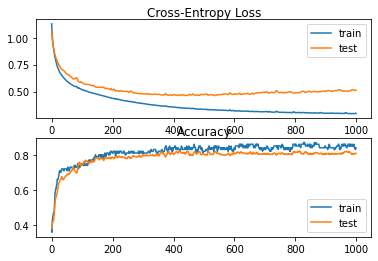

In [7]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [8]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.813


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 85% accuracy on the training dataset, which we know is optimistic, and about 81% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over the whole run, as we noted with the final scores. We can see that the model's accuracy has high variance on the training dataset compared to the test set, as we would expect. The variance in the model highlights the fact that choosing the model at the end of the run or any model from about epoch 400 is challenging as the accuracy on the training dataset has a high variance. We also see a muted version of the variance on the test dataset.

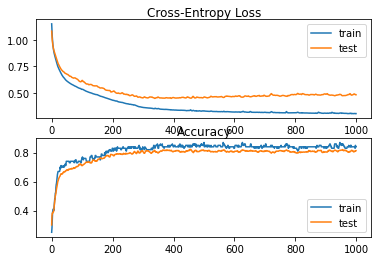

In [9]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### Save Horizontal Models

There may be many ways to implement a horizontal voting ensemble. Perhaps the simplest is to drive the training process manually, one epoch at a time, then save models at the end of the epoch if we have exceeded an upper limit on the number of epochs. For example, we will train the model for 1,000 epochs with our test problem and perhaps save models from epoch 950 onwards (e.g., between and including epochs 950 and 999).

In [10]:
# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
    # fit model for a single epoch
    model.fit(trainX, trainy, epochs=1, verbose=0)

    # check if we should save the model
    if i >= n_save_after:
        model.save('models/model_' + str(i) + '.h5')

Models can be saved to a file using the save() function on the model and specifying a filename that includes the epoch number. We will save all models under a new models/ folder in the current working directory to avoid clutter with our source files.

In [11]:
from os import makedirs

# create directory for models
makedirs('models', exist_ok =True)

Note, saving and loading neural network models in Keras requires that you have the h5py library installed. You can install this library using pip as follows:

```
pip install h5py
```

Tying all of this together, the complete example of fitting the model on the training dataset and saving all models from the last 50 epochs is listed below.

In [12]:
# save horizontal voting ensemble members during training
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from os import makedirs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# create directory for models
makedirs('models',exist_ok =True)

# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
    # fit model for a single epoch
    model.fit(trainX, trainy, epochs=1, verbose=0)
    
    # check if we should save the model
    if i >= n_save_after:
        model.save('models/model_' + str(i) + '.h5')

Running the example creates the models/ folder and saves 50 models into the directory. Note, to re-run this example, you must delete the models/ directory so that the script can recreate it.

### Make Horizontal Ensemble Predictions

Now that we have created the models, we can use them in a horizontal voting ensemble. First, we need to load the models into memory. This is reasonable as the models are small. If you are developing a horizontal voting ensemble with very large models, it might be easier to load models one at a time, make a prediction, then load the next model and repeat the process. The function `load_all_models()` below will load models from the models/ directory. It takes the start and end epochs as arguments so that you can experiment with different groups of models saved over contiguous epochs.

In [13]:
# load models from file
def load_all_models(n_start, n_end):
    all_models = list()
    for epoch in range(n_start, n_end):
        # define filename for this ensemble
        filename = 'models/model_' + str(epoch) + '.h5'

        # load model from file
        model = load_model(filename)

        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

We can call the function to load all of the models. We can then reverse the list of models so that the models at the end of the run are at the beginning of the list. This will be helpful later when we test voting ensembles of different sizes, including models sequentially from the end of the run backward through training epochs, in case the best models really were at the end of the run.

```
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))

# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
```

Next, we can evaluate each saved model on the test dataset and a voting ensemble of the last n contiguous models from training. We want to know how well each model actually performed on the test dataset and, importantly, the distribution of model performance on the test dataset so that we know how well (or poorly) an average model chosen from the end of the run would perform in practice. We don't know how many members to include in the horizontal voting ensemble. Therefore, we can test different numbers of contiguous members, working backward from the final model.

First, we need a function to make a prediction with a list of ensemble members. Each member predicts the probabilities for each of the three output classes. The probabilities are added, and we use an argmax to select the class with the most support. The `ensemble_predictions()` function below implements this voting-based prediction scheme.

In [14]:
# make an ensemble prediction for multiclass classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

Next, we need a function to evaluate a subset of the ensemble members of a given size. The subset needs to be selected, predictions made, and the ensemble's performance estimated by comparing the predictions to the expected values. The `evaluate_n_members()` function below implements this ensemble size evaluation.

In [15]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

We can now enumerate through different sized horizontal voting ensembles from 1 to 50. Each member is evaluated alone, then the ensemble of that size is evaluated, and scores are recorded.

```
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)

    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)

    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
```

At the end of the evaluations, we report the distribution of scores of single models on the test dataset. The average score is what we would expect on average if we picked any of the saved models as a final model.

```
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
```

Finally, we can plot the scores. The scores of each standalone model are plotted as blue dots, and a line plot is created for each ensemble of contiguous models (orange).

```
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()
```

Our expectation is that a fair-sized ensemble will outperform a randomly selected model and that there is a point of diminishing returns in choosing the ensemble size. The complete example is listed below.

In [16]:
# load models and make predictions using a horizontal voting ensemble
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot

from numpy import mean, std, array, argmax
import numpy

# load models from file
def load_all_models(n_start, n_end):
    all_models = list()
    for epoch in range(n_start, n_end):
        # define filename for this ensemble
        filename = 'models/model_' + str(epoch) + '.h5'

        # load model from file
        model = load_model(filename)

        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)

    return all_models

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

First, the 50 saved models are loaded into memory.

In [17]:
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))

>loaded models/model_950.h5
>loaded models/model_951.h5
>loaded models/model_952.h5
>loaded models/model_953.h5
>loaded models/model_954.h5
>loaded models/model_955.h5
>loaded models/model_956.h5
>loaded models/model_957.h5
>loaded models/model_958.h5
>loaded models/model_959.h5
>loaded models/model_960.h5
>loaded models/model_961.h5
>loaded models/model_962.h5
>loaded models/model_963.h5
>loaded models/model_964.h5
>loaded models/model_965.h5
>loaded models/model_966.h5
>loaded models/model_967.h5
>loaded models/model_968.h5
>loaded models/model_969.h5
>loaded models/model_970.h5
>loaded models/model_971.h5
>loaded models/model_972.h5
>loaded models/model_973.h5
>loaded models/model_974.h5
>loaded models/model_975.h5
>loaded models/model_976.h5
>loaded models/model_977.h5
>loaded models/model_978.h5
>loaded models/model_979.h5
>loaded models/model_980.h5
>loaded models/model_981.h5
>loaded models/model_982.h5
>loaded models/model_983.h5
>loaded models/model_984.h5
>loaded models/model

Next, the performance of every single model is evaluated on the holdout test dataset, and the ensemble of that size (1, 2, 3, etc.) is created and evaluated on the holdout test dataset.

In [18]:
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)

    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)

    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

> 1: single=0.808, ensemble=0.808
> 2: single=0.808, ensemble=0.807
> 3: single=0.810, ensemble=0.808
> 4: single=0.810, ensemble=0.808
> 5: single=0.809, ensemble=0.808
> 6: single=0.806, ensemble=0.808
> 7: single=0.806, ensemble=0.809
> 8: single=0.807, ensemble=0.807
> 9: single=0.810, ensemble=0.806
> 10: single=0.810, ensemble=0.808
> 11: single=0.809, ensemble=0.810
> 12: single=0.810, ensemble=0.810
> 13: single=0.809, ensemble=0.809
> 14: single=0.809, ensemble=0.810
> 15: single=0.809, ensemble=0.809
> 16: single=0.809, ensemble=0.809
> 17: single=0.808, ensemble=0.810
> 18: single=0.806, ensemble=0.810
> 19: single=0.806, ensemble=0.810
> 20: single=0.807, ensemble=0.810
> 21: single=0.806, ensemble=0.810
> 22: single=0.807, ensemble=0.810
> 23: single=0.808, ensemble=0.810
> 24: single=0.807, ensemble=0.810
> 25: single=0.809, ensemble=0.810
> 26: single=0.807, ensemble=0.809
> 27: single=0.808, ensemble=0.810
> 28: single=0.807, ensemble=0.810
> 29: single=0.806, ensemble=

Roughly, we can see that the ensemble appears to outperform most single models, consistently achieving an accuracy of around 81.8%. Next, the distribution of the accuracy of single models is reported. We can see that picking any of the saved models at random would result in a model with an accuracy of 81.6% on average with a reasonably tight standard deviation of 0.3%. We would require that a horizontal ensemble outperform this average to be useful.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In [19]:
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

Accuracy 0.809 (0.002)


Finally, a graph is created summarizing the performance of every single model (blue dot) and the ensemble of each size from 1 to 50 members. We can see from the blue dots that there is no structure to the models over the epochs, e.g., if the last models during training were better, there would be a downward trend in the accuracy from left to right. We can see that as we add more ensemble members, the better the performance of the horizontal voting ensemble in the orange line. We can see a flattening of performance on this problem, perhaps between 23 and 33 epochs; that might be a good choice.

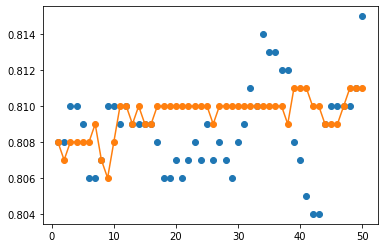

In [20]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Dataset Size**. Repeat the experiments with a smaller or larger-sized dataset with a similar ratio of training to test examples.
* **Larger Ensemble**. Re-run the example with hundreds of final models and report the impact of the large ensemble sizes of accuracy on the test set.
* **Random Sampling of Models**. Re-run the example and compare the performance of ensembles of the same size with models saved over contiguous epochs to a random selection of saved models.

## Summary

In this tutorial, you discovered how to reduce the variance of a final deep learning neural network model using a horizontal voting ensemble. Specifically, you learned:

* It is challenging to choose a final neural network model that has high variance on a training dataset.
* Horizontal voting ensembles provide a way to reduce variance and improve average model performance for models with high variance using a single training run.
* How to develop a horizontal voting ensemble in Python using Keras to improve the performance of a final  Multilayer Perceptron model for multiclass classification.